     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=411f1b24bb21db4efed9c01a26f00c79331a32d58a4d3dc2420d75db61385338
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize-matplotlib
■ 前処理後のデータの最初の5行
   year  month  temperature    time_dt  year_from_2000
0  2020      1          4.5 2020-01-01              20
1  2020      2          5.7 2020-02-01              20
2  2020      3          8.7 2020-03-01              20
3  2020      4         12.1 2020-04-01              20
4  2020      5         18.1 2020-05-01              20

■ 前処理後のデータの基本情報
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -

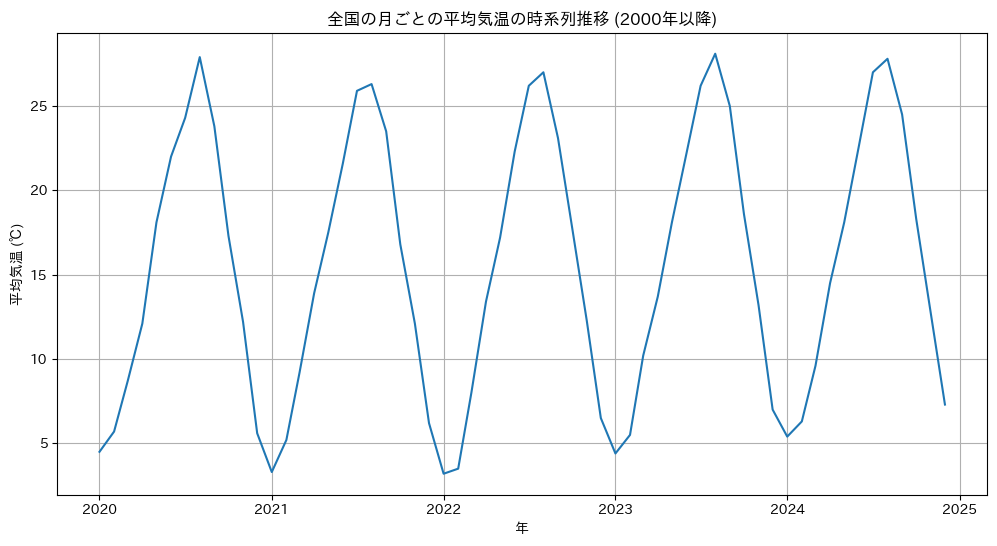

In [ ]:
# Google Colabで日本語を表示するためのライブラリをインストール
!pip install japanize-matplotlib

# 必要なライブラリをインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import japanize_matplotlib  # 日本語化ライブラリのインポート
from datetime import datetime
import os # フォルダ作成のためにosモジュールをインポート

# --- 1. データの読み込みと前処理 ---
# Google DriveにマウントしたCSVファイルのパスを指定
# ※2つ提示されたうち、より具体的なファイル名を選択しました
file_path = '/content/drive/MyDrive/Colab Notebooks/csv置き場/015/temperature_data.csv'

df_original = pd.read_csv(file_path)

# カラム名を確認し、時系列データと金額データのカラムを特定
# データフレームの最初の数行から、時系列データは4列目 (インデックス3)、金額データは6列目 (インデックス5)にあると推測
# 実際のカラム名とデータを確認して調整してください。ここではインデックスで指定します。
# 新しいCSVの構成に合わせてカラムインデックスを変更
year_column_index = 0 # '年' カラム
month_column_index = 1 # '月' カラム
temp_column_index = 2 # '平均気温(℃)' カラム


# 必要なカラムだけを抽出
df_extracted = df_original.iloc[:, [year_column_index, month_column_index, temp_column_index]].copy() # .copy() を追加してSettingWithCopyWarningを防ぐ

# カラム名を分かりやすいものに変更
df_extracted.columns = ['year', 'month', 'temperature']

# 'year'と'month'カラムを組み合わせてdatetime型に変換
def create_datetime(row):
    try:
        return datetime(int(row['year']), int(row['month']), 1) # 日は1日として扱う
    except ValueError:
        return None

df_extracted['time_dt'] = df_extracted.apply(create_datetime, axis=1)


# 温度カラムを数値型に変換（既に数値型であれば不要だが、念のため）
df_extracted['temperature'] = pd.to_numeric(df_extracted['temperature'], errors='coerce')


# 元のデータフレームを抽出したデータフレームに置き換え
# df = df_extracted.copy() # この行を削除またはコメントアウト

# 分析しやすいように、基準年（2000年）からの経過年数を計算
df_extracted['year_from_2000'] = df_extracted['time_dt'].dt.year - 2000 # df_extracted にカラムを追加

# 最終的に使用するデータフレームをdfとする
df = df_extracted.copy()


print("■ 前処理後のデータの最初の5行")
print(df.head())
print("\n■ 前処理後のデータの基本情報")
df.info()
print("\n■ 処理後の欠損値の数")
print(df.isnull().sum())

# 欠損値を含む行があれば削除し、分析の準備を完了させる
df.dropna(inplace=True)
print(f"\n■ 欠損値処理後のデータ件数: {len(df)}")

# --- グラフで視覚的にデータを確認する ---
plt.figure(figsize=(12, 6))
sns.lineplot(x='time_dt', y='temperature', data=df) # y軸をtemperatureに変更
plt.title('全国の月ごとの平均気温の時系列推移 (2000年以降)') # タイトルを変更
plt.xlabel('年')
plt.ylabel('平均気温 (℃)') # y軸ラベルを変更
plt.grid(True)

# グラフを保存
today_str = datetime.now().strftime('%Y%m%d')
file_name = f"{today_str}_全国平均気温_時系列推移.png" # ファイル名を変更
save_dir = '/content/drive/MyDrive/Colab Notebooks/csv置き場' # 保存先ディレクトリ
save_path = os.path.join(save_dir, file_name) # 保存先パスを生成

# 保存先ディレクトリが存在しない場合は作成
os.makedirs(save_dir, exist_ok=True)

plt.savefig(save_path)

plt.show()

In [ ]:
# 'temperature'と'year_from_2000'の要約統計量を表示
print(df[['temperature', 'year_from_2000']].describe())

       temperature  year_from_2000
count    60.000000       60.000000
mean     15.508333       22.000000
std       7.975647        1.426148
min       3.200000       20.000000
25%       7.825000       21.000000
50%      15.650000       22.000000
75%      22.725000       23.000000
max      28.100000       24.000000


■ 箱ひげ図描画直前の 'temperature' カラムのデータの最初の5行
0     4.5
1     5.7
2     8.7
3    12.1
4    18.1
Name: temperature, dtype: float64

■ 箱ひげ図描画直前の 'temperature' カラムのデータの基本統計量
count    60.000000
mean     15.508333
std       7.975647
min       3.200000
25%       7.825000
50%      15.650000
75%      22.725000
max      28.100000
Name: temperature, dtype: float64


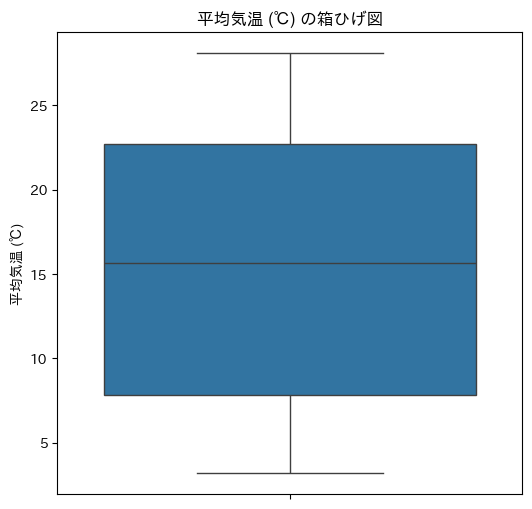

In [ ]:
import os # Import os for directory creation
from datetime import datetime # Import datetime for file naming
import pandas as pd # Import pandas to display data info
import seaborn as sns # Import seaborn for plotting
import matplotlib.pyplot as plt # Import matplotlib for plotting


# ■ デバッグ用: 箱ひげ図を描画する直前の 'temperature' カラムのデータを確認
print("■ 箱ひげ図描画直前の 'temperature' カラムのデータの最初の5行")
print(df['temperature'].head())
print("\n■ 箱ひげ図描画直前の 'temperature' カラムのデータの基本統計量")
print(df['temperature'].describe())


# 'temperature'の箱ひげ図を表示
plt.figure(figsize=(6, 6)) # グラフサイズを調整
sns.boxplot(y='temperature', data=df)
plt.title('平均気温 (℃) の箱ひげ図')
plt.ylabel('平均気温 (℃)')

# グラフを保存
today_str = datetime.now().strftime('%Y%m%d')
file_name = f"{today_str}_平均気温_箱ひげ図.png"
save_dir = '/content/drive/MyDrive/Colab Notebooks/csv置き場' # 保存先ディレクトリ
save_path = os.path.join(save_dir, file_name) # 保存先パスを生成

# 保存先ディレクトリが存在しない場合は作成
os.makedirs(save_dir, exist_ok=True)

plt.savefig(save_path)

plt.show()

In [ ]:
df['time_index'] = (df['time_dt'].dt.year - 2000) * 12 + (df['time_dt'].dt.month - 1)
df['time_index'] = df['time_index'].astype(int)

print("■ 新しい 'time_index' カラムが追加されたデータフレームの最初の5行")
print(df.head())

■ 新しい 'time_index' カラムが追加されたデータフレームの最初の5行
   year  month  temperature    time_dt  year_from_2000  time_index
0  2020      1          4.5 2020-01-01              20         240
1  2020      2          5.7 2020-02-01              20         241
2  2020      3          8.7 2020-03-01              20         242
3  2020      4         12.1 2020-04-01              20         243
4  2020      5         18.1 2020-05-01              20         244


Output()

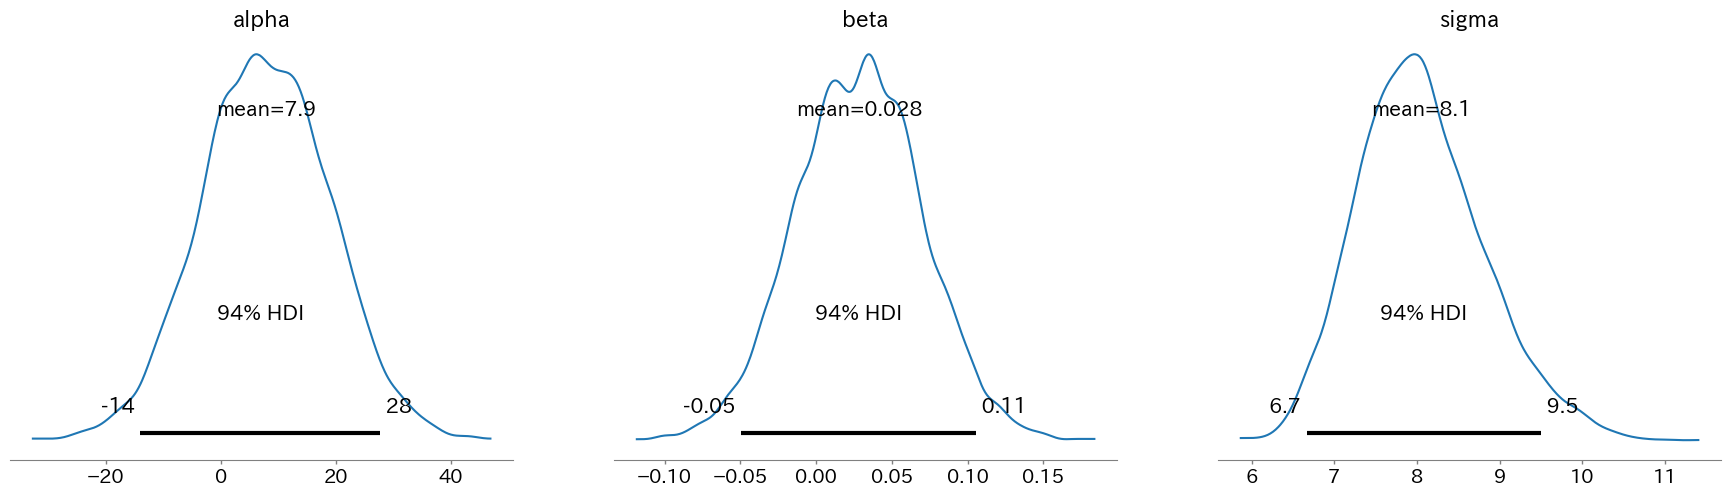

In [ ]:
# 分析に使用するデータを抽出
y = df['temperature'].values # 'yen' を 'temperature' に変更

with pm.Model() as model:
    # x を pm.Data として定義
    # 予測変数として 'year_from_2000' の代わりに 'time_index' を使用
    x = pm.Data('x', df['time_index'].values)

    # --- 事前分布の設定 ---
    # alpha（切片）: 気温の平均値を中心とする弱い情報事前分布。大きな外れ値は考えにくい。
    alpha = pm.Normal('alpha', mu=y.mean(), sigma=y.std() * 2)
    # beta（傾き）: 時間経過の効果。上がるか下がるか不明なため、0を中心とする無情報に近い事前分布。
    beta = pm.Normal('beta', mu=0, sigma=y.std()) # sigmaを調整
    # sigma（ばらつき）: 気温のばらつき。正の値しか取らないため半正規分布を使用。
    sigma = pm.HalfNormal('sigma', sigma=y.std())

    # --- モデルの定義 ---
    # 線形回帰モデルを定義。気温(temperature)は、経過月数(x)によって決まる平均値の周りに正規分布すると仮定。
    mu = alpha + beta * x
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)

    # --- サンプリングの実行 ---
    # MCMC（マルコフ連鎖モンテカルロ法）を用いて事後分布からサンプリング
    idata = pm.sample(2000, tune=1000, chains=4, random_seed=42)

# --- 結果の可視化 ---
# 事後分布をプロットして結果を確認
az.plot_posterior(idata, var_names=['alpha', 'beta', 'sigma'])

# グラフを保存
today_str = datetime.now().strftime('%Y%m%d')
file_name = f"{today_str}_平均気温_事後分布.png" # ファイル名を変更
save_dir = '/content/drive/MyDrive/Colab Notebooks/csv置き場' # 保存先ディレクトリ
save_path = os.path.join(save_dir, file_name) # 保存先パスを生成

# 保存先ディレクトリが存在しない場合は作成
os.makedirs(save_dir, exist_ok=True)

plt.savefig(save_path)

plt.show()

Output()

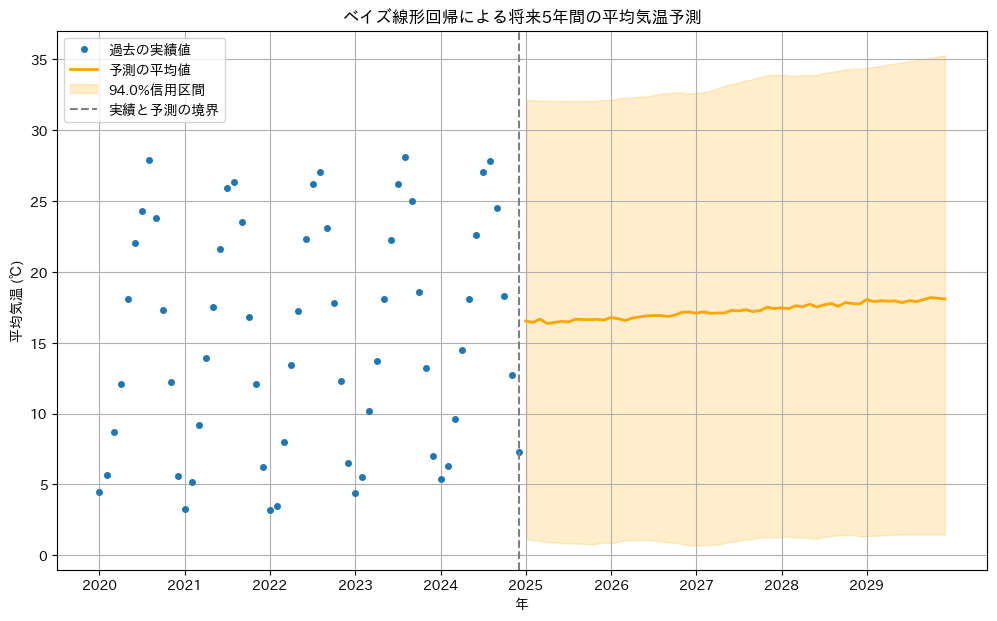

---　予測結果の要約　---
年月: 平均 (信用区間)
2025年01月: 16.53 (0.95 〜 32.26)
2025年02月: 16.42 (0.77 〜 31.75)
2025年03月: 16.66 (1.51 〜 32.79)
2025年04月: 16.34 (0.81 〜 31.80)
2025年05月: 16.42 (0.80 〜 31.67)
2025年06月: 16.50 (1.32 〜 32.08)
2025年07月: 16.45 (0.70 〜 31.63)
2025年08月: 16.65 (1.27 〜 32.50)
2025年09月: 16.63 (0.88 〜 32.10)
2025年10月: 16.61 (0.35 〜 32.03)
2025年11月: 16.64 (0.27 〜 32.22)
2025年12月: 16.59 (1.19 〜 32.18)
2026年01月: 16.78 (1.15 〜 31.87)
2026年02月: 16.68 (0.82 〜 32.38)
2026年03月: 16.56 (0.76 〜 31.51)
2026年04月: 16.73 (1.28 〜 32.60)
2026年05月: 16.81 (1.38 〜 32.11)
2026年06月: 16.89 (1.53 〜 32.81)
2026年07月: 16.91 (0.36 〜 32.37)
2026年08月: 16.91 (1.18 〜 33.06)
2026年09月: 16.85 (1.72 〜 32.94)
2026年10月: 16.94 (-0.31 〜 31.52)
2026年11月: 17.14 (0.87 〜 32.89)
2026年12月: 17.16 (0.58 〜 32.20)
2027年01月: 17.08 (1.52 〜 33.23)
2027年02月: 17.17 (0.48 〜 33.11)
2027年03月: 17.07 (0.59 〜 32.20)
2027年04月: 17.09 (0.70 〜 32.85)
2027年05月: 17.09 (0.97 〜 32.79)
2027年06月: 17.28 (0.68 〜 32.55)
2027年07月: 17.23 (1.09 〜 34.01)
2027年08月

In [ ]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import japanize_matplotlib # 日本語化
import xarray as xr # Import xarray
import matplotlib.dates as mdates # Import for date formatting

def plot_forecast(
    model,
    idata,
    df,
    years_to_predict=5,
    hdi_prob=0.94,
    x_col='time_index', # x_col を 'time_index' に変更
    y_col='temperature', # 'yen' を 'temperature' に変更
    time_col='time_dt',
    save_dir='/content/drive/MyDrive/Colab Notebooks/csv置き場'
):
    """
    ベイズモデルの将来予測を行い、結果をプロット・保存・要約する関数。

    Args:
        model: 学習済みのPyMCモデル。
        idata: サンプリング結果のInferenceData。
        df: 訓練に使用した元のDataFrame。
        years_to_predict (int): 予測する年数。
        hdi_prob (float): 信用区間の確率。
        x_col (str): 時間を表す列名（経過月数）。
        y_col (str): 目的変数の列名。
        time_col (str): 日付・時刻の列名。
        save_dir (str): グラフの保存先ディレクトリ。
    """
    # --- 1. 予測期間の準備 ---
    # 最後の月のtime_indexを取得
    last_time_index = df[x_col].max()
    # 予測する期間の月数
    months_to_predict = years_to_predict * 12
    # 予測期間のtime_indexを生成
    future_x_values = np.arange(last_time_index + 1, last_time_index + months_to_predict + 1)

    # 予測期間のtime_dtを作成（要約出力用）
    last_date = df[time_col].max()
    future_dates = [last_date + pd.DateOffset(months=i) for i in range(1, months_to_predict + 1)]


    # --- 2. 予測の実行 ---
    with model:
        # Check if x_future Data variable already exists
        if "x_future" not in model.named_vars:
            # Define a new pm.Data for future x values if it doesn't exist
            x_future = pm.Data("x_future", future_x_values)
            # Define the mean for future predictions using the trained parameters
            mu_pred = model.alpha + model.beta * x_future
            # Define the likelihood for future predictions without observed data
            likelihood_pred = pm.Normal("likelihood_pred", mu=mu_pred, sigma=model.sigma)
        else:
            # If x_future exists, just set its value
            pm.set_data({"x_future": future_x_values})
            # Access the existing prediction likelihood variable
            likelihood_pred = model.named_vars["likelihood_pred"]


        # Sample from the posterior predictive distribution for the future data
        # Ensure the new likelihood variable is sampled
        posterior_predictive = pm.sample_posterior_predictive(
            idata, var_names=[likelihood_pred.name], random_seed=42
        )

    # --- 3. グラフの描画 ---
    # Access the data using dictionary-like indexing
    # y_pred_data has shape (n_future_points, sample) after az.extract(group="posterior_predictive")
    y_pred_data = az.extract(posterior_predictive, group="posterior_predictive")[likelihood_pred.name]

    # Reshape y_pred_data to (chain, draw, n_future_points) for az.hdi
    n_chains = idata.posterior.sizes['chain']
    n_draws = idata.posterior.sizes['draw']
    n_future_points = y_pred_data.shape[0] # Should be months_to_predict

    # Reshape from (n_future_points, sample) to (n_future_points, chain, draw)
    y_pred_data_reshaped = y_pred_data.values.reshape(n_future_points, n_chains, n_draws)
    # Transpose to (chain, draw, n_future_points)
    y_pred_data_for_hdi = y_pred_data_reshaped.transpose(1, 2, 0)

    # Convert back to DataArray with correct dimensions
    y_pred_data_for_hdi_da = xr.DataArray(
        y_pred_data_for_hdi,
        coords={'chain': np.arange(n_chains), 'draw': np.arange(n_draws), 'likelihood_pred_dim_0': np.arange(n_future_points)},
        dims=['chain', 'draw', 'likelihood_pred_dim_0']
    )


    plt.figure(figsize=(12, 7))
    # 過去の実績をプロット - Use time_index for x-axis
    plt.plot(df['time_index'], df[y_col], 'o', ms=4, label='過去の実績値')

    # 予測の平均値をプロット - Use future_x_values (time_index) for x-axis
    # Calculate mean over the 'sample' dimension from the original extracted data
    y_pred_mean = y_pred_data.mean(dim="sample")
    plt.plot(future_x_values, y_pred_mean, '-', lw=2, color='orange', label='予測の平均値')

    # 予測の信用区間をプロット
    # Calculate HDI using the reshaped DataArray
    hdi_data_plot = az.hdi(y_pred_data_for_hdi_da, hdi_prob=hdi_prob) # az.hdi returns a DataArray with hdi dim

    # az.plot_hdi expects x with shape (n_points,) and hdi_data with shape (n_points, 2)
    # Pass hdi_data explicitly to plot_hdi
    # Ensure x-values are 1-dimensional
    az.plot_hdi(x=future_x_values, hdi_data=hdi_data_plot, hdi_prob=hdi_prob, color='orange', fill_kwargs={'alpha': 0.2, 'label': f'{hdi_prob*100}%信用区間'})

    # ★改善点★ 過去と未来の境界線を描画 - Use the last time_index
    last_actual_time_index = df['time_index'].max()
    plt.axvline(x=last_actual_time_index, color='gray', linestyle='--', label='実績と予測の境界')

    # Set x-axis ticks and labels to represent years
    # Calculate tick positions and labels
    min_time_index = df['time_index'].min()
    max_time_index = future_x_values.max()

    # Create tick positions every 12 months (1 year)
    tick_positions = np.arange(min_time_index, max_time_index + 1, 12)
    # Create tick labels as years (starting from 2000)
    tick_labels = [str(2000 + int(pos / 12)) for pos in tick_positions]

    plt.xticks(tick_positions, tick_labels)


    plt.title(f'ベイズ線形回帰による将来{years_to_predict}年間の平均気温予測') # タイトルを修正
    plt.xlabel('年')
    plt.ylabel('平均気温 (℃)') # y軸ラベルを修正
    plt.legend()
    plt.grid(True)

    # グラフを保存
    today_str = datetime.now().strftime('%Y%m%d')
    file_name = f"{today_str}_平均気温予測_{years_to_predict}年.png" # ファイル名を修正
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, file_name))

    plt.show()

    # --- 4. ★改善点★ 予測結果の要約を出力 ---
    print("---　予測結果の要約　---")
    # Calculate HDI separately for summary - use the reshaped data
    hdi_data_summary = az.hdi(y_pred_data_for_hdi_da, hdi_prob=hdi_prob) # az.hdi returns a DataArray with hdi dim
    print("年月: 平均 (信用区間)")
    # Get the name of the variable in the hdi_data_summary Dataset
    # Based on the error, it's likely 'likelihood_pred_dim_0'
    hdi_var_name = list(hdi_data_summary.data_vars.keys())[0] # Get the first (and likely only) variable name


    for i, date in enumerate(future_dates):
        mean_val = y_pred_mean[i].item()
        # Access HDI values correctly from the hdi_data_summary DataArray within the Dataset
        # Use the determined hdi_var_name to access the DataArray
        lower_hdi = hdi_data_summary[hdi_var_name].isel({'likelihood_pred_dim_0': i, 'hdi': 0}).item()
        upper_hdi = hdi_data_summary[hdi_var_name].isel({'likelihood_pred_dim_0': i, 'hdi': 1}).item()


        print(f"{date.strftime('%Y年%m月')}: {mean_val:.2f} ({lower_hdi:.2f} 〜 {upper_hdi:.2f})")


# --- 関数の使い方 ---
# model, idata, df が存在することを前提として、関数を呼び出すだけ
plot_forecast(model, idata, df, years_to_predict=5, time_col='time_dt')